# 02_Model_Dev: Model Development

This notebook develops the forecasting model for Oddbox’s weekly box demand, based on the EDA insights and modular architecture defined earlier.

Our approach decomposes total demand into interpretable and modular components — each aligned to business logic and real-world drivers like subscribers, promotions, and seasonal effects. We intentionally avoid black-box monoliths and instead opt for a stack of smaller, explainable models.

---

## Notebook Purpose

- Implement the **layered forecasting framework**:
  1. Subscriber projection
  2. Box type demand share modeling
  3. Adjustment for marketing and holidays
- Engineer time-aware and domain-driven features
- Train a main model (e.g., LightGBM or XGBoost) with baselines for comparison
- Add stretch layer for uncertainty-aware predictions (quantiles or bootstraps)
- Output clean forecasts for each box type over the next 4 weeks

---

## Notebook Structure

### 5. Adjustment Layer
- Apply uplift factors for marketing and holiday weeks
- Compare pre- and post-adjustment forecasts

### 6. Forecast Generation
- Predict next 4 weeks for each box type
- Include confidence intervals or quantiles if possible

### 7. Output & Visualisation
- Save to `forecast.csv`
- Generate visual plots: Actual vs Predicted with confidence bands

---

## Core Assumptions

- Short-horizon subscriber counts are predictable with autoregressive logic
- Box type preferences are stable and separable from total volume
- Promotions and holidays have measurable, quantifiable impacts
- Engineered features can compensate for data sparsity and noise

## 1. Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import importlib

# Model libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb

# Custom modules
from oddbox_forecasting import (
    config, 
    pipeline
)
importlib.reload(pipeline)

# Display settings
pd.set_option("display.max_columns", None)

In [13]:
# Directories
raw_path = Path("../data/raw/data.csv")
processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

# Load latest processed file or generate it if none exists
processed_files = sorted(processed_dir.glob("*_processed.csv"))

if processed_files:
    latest_file = processed_files[-1]
    print(f"Loading existing processed file: {latest_file.name}")
    df = pd.read_csv(latest_file)
else:
    print("No processed file found. Running pipeline...")
    df = pipeline.load_and_prepare(raw_path)

df.head()

No processed file found. Running pipeline...
Integrity Report: {'missing': week                       0
box_type                   0
box_orders                 0
is_marketing_week          0
holiday_week               0
weekly_subscribers         0
fortnightly_subscribers    0
dtype: int64, 'duplicates': np.int64(0), 'rows_per_week': {8: 52}}
Processed data saved to: ../data/processed/20250616_104130_processed.csv


,week,box_type,box_orders,is_marketing_week,holiday_week,weekly_subscribers,fortnightly_subscribers,weekly_subscribers_lag_1,weekly_subscribers_lag_2,box_orders_lag_1,box_orders_lag_2,box_orders_rollmean,box_orders_rollstd,is_event_week,weekofyear,week_sin,week_cos,marketing_x_box,holiday_x_box,box_orders_volatility
0,2024-04-15,LFV,79,0,0,483,167.0,NaN,NaN,NaN,NaN,NaN,NaN,0,16,0.935016,-0.354605,LFV_MKT_0,LFV_HOL_0,NaN
1,2024-04-15,LV,79,0,0,483,167.0,NaN,NaN,NaN,NaN,NaN,NaN,0,16,0.935016,-0.354605,LV_MKT_0,LV_HOL_0,NaN
2,2024-04-15,MFV,84,0,0,483,167.0,NaN,NaN,NaN,NaN,NaN,NaN,0,16,0.935016,-0.354605,MFV_MKT_0,MFV_HOL_0,NaN
3,2024-04-15,MV,78,0,0,483,167.0,NaN,NaN,NaN,NaN,NaN,NaN,0,16,0.935016,-0.354605,MV_MKT_0,MV_HOL_0,NaN
4,2024-04-15,SFV,82,0,0,483,167.0,NaN,NaN,NaN,NaN,NaN,NaN,0,16,0.935016,-0.354605,SFV_MKT_0,SFV_HOL_0,NaN


## 2. Feature Preparation
We prepare the dataset for a range of modelling tasks:

- **Baseline Forecasts**: Require simple historical aggregation (e.g., mean, seasonal naïve)
- **ML Models**: Use engineered features with LightGBM/XGBoost per box type
- **Adjustments**: Need marketing and holiday week flags for post-hoc uplift modeling
- **Forecasting**: Prepare the final dataset structure to support rolling forecasts

In [22]:
# Drop rows with NaNs (from lag/rolling features)
df_model = df.dropna().copy()
print(f"Rows after dropping NaNs: {len(df_model)}")

# Define target
target_col = "box_orders"

# Core features for ML models
feature_cols = [
    # Subscriber signals
    "weekly_subscribers",
    "fortnightly_subscribers",
    "weekly_subscribers_lag_1",
    "weekly_subscribers_lag_2",
    
    # Box order history
    "box_orders_lag_1",
    "box_orders_lag_2",
    "box_orders_rollmean",
    "box_orders_rollstd",
    "box_orders_volatility",
    
    # Time-based signals
    "week_sin",
    "week_cos",
    
    # Event flags
    "is_marketing_week",
    "holiday_week",
    "is_event_week",
    
    # Interaction (for later use in adjustment layers)
    "marketing_x_box",
    "holiday_x_box",
]

# Confirm features are present
missing = [f for f in feature_cols if f not in df_model.columns]
assert not missing, f"Missing expected features: {missing}"

# Subset feature matrix and target
X_all = df_model[feature_cols].copy()
y_all = df_model[target_col].copy()

print(f"X_all shape: {X_all.shape}")
print(f"y_all shape: {y_all.shape}")

# Store per-box-type slices (for ML or baseline modeling later)
box_type_dfs = {
    box: group.dropna(subset=feature_cols + [target_col])
    for box, group in df_model.groupby("box_type")
}


Rows after dropping NaNs: 400
X_all shape: (400, 16)
y_all shape: (400,)


## 3. Baseline Forecasts
We begin with two simple baselines to set reference performance levels for our forecasting models.

#### 1. Rolling Average (Last 3 Weeks)
- **Method**: Uses the mean of the previous 3 weeks' box_orders to forecast the next 4 weeks.
- **Why it works**: Captures local trends and noise smoothing. Especially useful when demand is stable but not highly seasonal.
- **Weakness**: Fails to account for seasonality or known demand dips (e.g., holidays).

#### 2. Seasonal Naïve
- **Method**: Repeats the same value from the same week(s) last year.
- **Why it works**: Effective if demand follows a strong yearly seasonal pattern.
- **Limitations**: Requires a full year of history to operate; may fall back to rolling average otherwise.

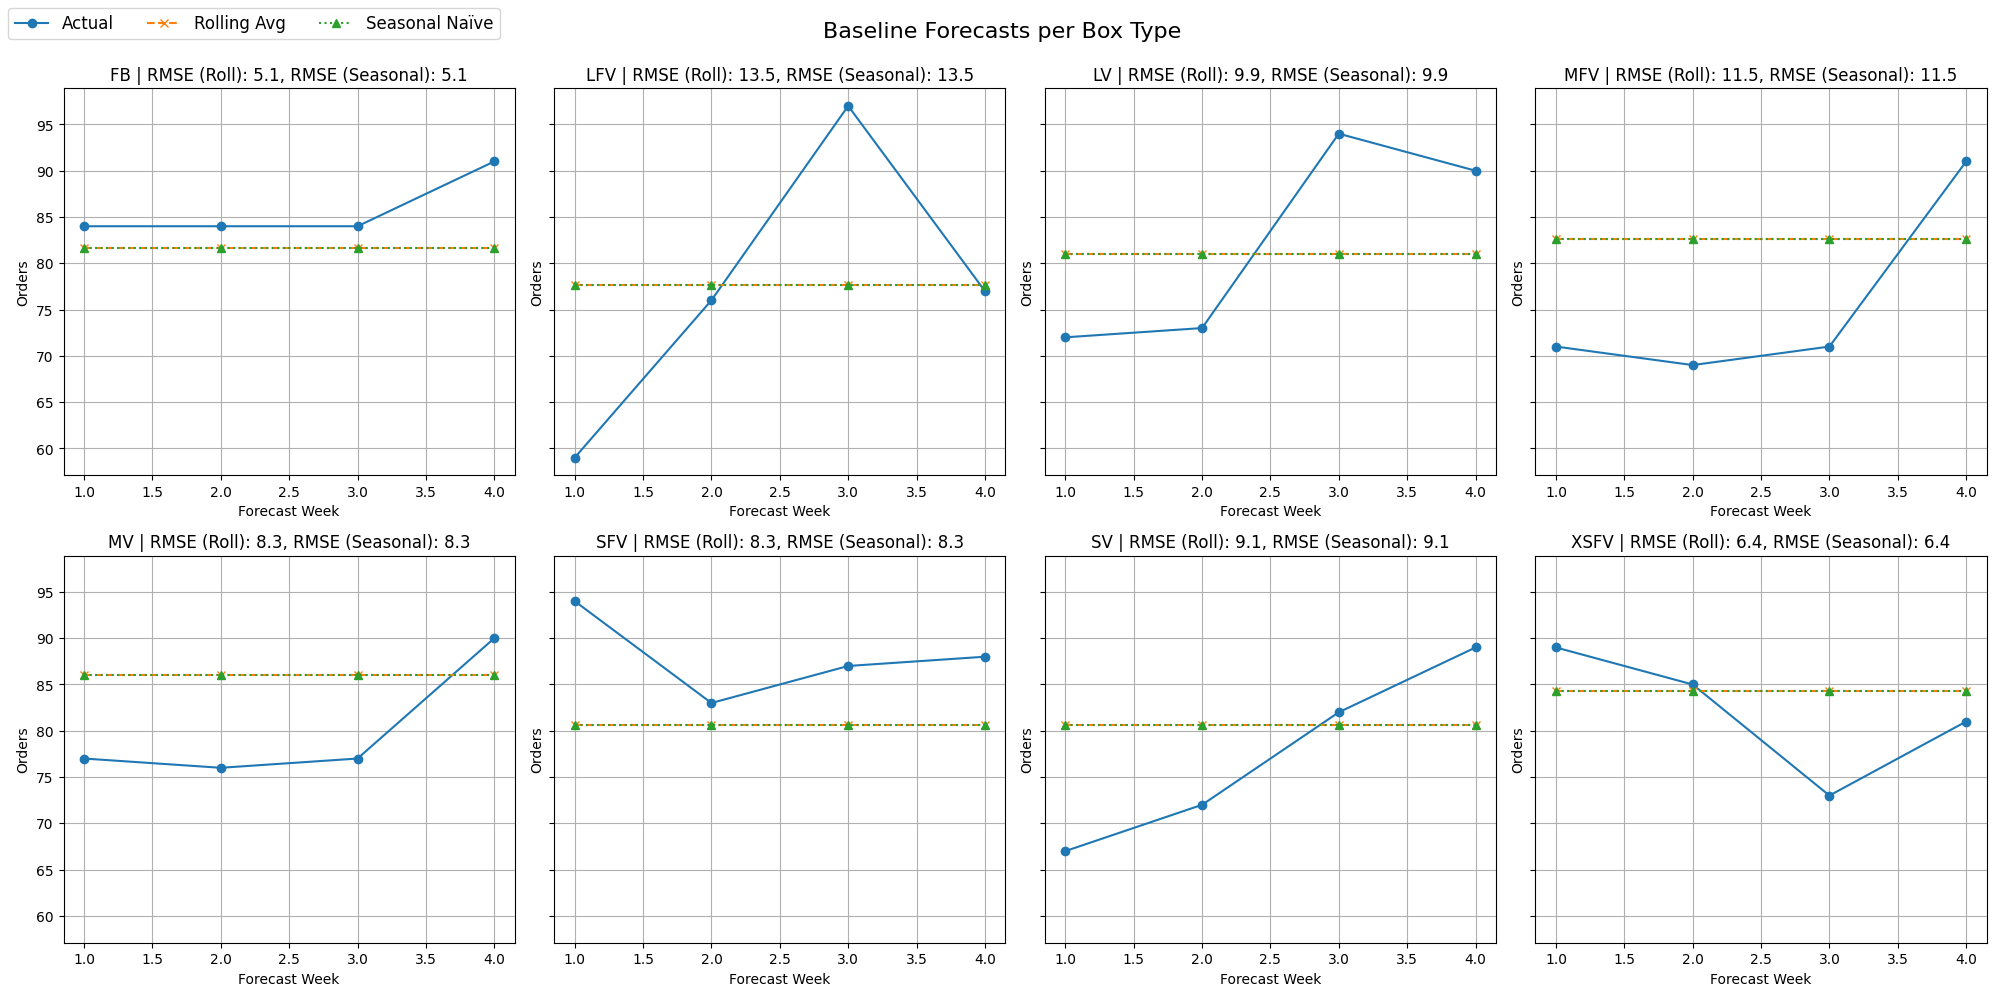

In [26]:
# Forecasting horizon
FORECAST_HORIZON = 4

# Store results
baseline_results = {}

# Forecast per box type
for box, group in df.groupby("box_type"):
    group = group.sort_values("week").copy()
    past_orders = group["box_orders"].iloc[:-FORECAST_HORIZON]

    # Rolling average (last 3 weeks)
    rolling_mean = past_orders.rolling(window=3).mean().iloc[-1]
    rolling_forecast = [rolling_mean] * FORECAST_HORIZON

    # Seasonal naive: same week last year
    last_year_indices = [-FORECAST_HORIZON - 52 + i for i in range(FORECAST_HORIZON)]
    if all(idx >= 0 for idx in last_year_indices):
        seasonal_naive_forecast = group["box_orders"].iloc[last_year_indices].tolist()
    else:
        seasonal_naive_forecast = rolling_forecast  # fallback

    # Actuals
    actual = group["box_orders"].iloc[-FORECAST_HORIZON:].tolist()

    # Metrics
    rmse_roll = np.sqrt(mean_squared_error(actual, rolling_forecast))
    mae_roll = mean_absolute_error(actual, rolling_forecast)

    rmse_seasonal = np.sqrt(mean_squared_error(actual, seasonal_naive_forecast))
    mae_seasonal = mean_absolute_error(actual, seasonal_naive_forecast)

    # Save
    baseline_results[box] = {
        "actual": actual,
        "rolling_forecast": rolling_forecast,
        "seasonal_naive": seasonal_naive_forecast,
        "rmse_roll": rmse_roll,
        "mae_roll": mae_roll,
        "rmse_seasonal": rmse_seasonal,
        "mae_seasonal": mae_seasonal,
    }

# Plotting all box types
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
axes = axes.flatten()

for idx, (box, res) in enumerate(baseline_results.items()):
    ax = axes[idx]
    x = range(1, FORECAST_HORIZON + 1)

    ax.plot(x, res["actual"], marker="o", label="Actual")
    ax.plot(x, res["rolling_forecast"], marker="x", linestyle="--", label="Rolling Avg")
    ax.plot(x, res["seasonal_naive"], marker="^", linestyle=":", label="Seasonal Naïve")

    ax.set_title(
        f"{box} | RMSE (Roll): {res['rmse_roll']:.1f}, RMSE (Seasonal): {res['rmse_seasonal']:.1f}"
    )
    ax.set_xlabel("Forecast Week")
    ax.set_ylabel("Orders")
    ax.grid(True)

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Baseline Forecasts per Box Type", fontsize=16)
plt.show()


##### Observations
- Across most box types, the **rolling average baseline performs reasonably well**, especially for stable boxes like `LV` and `FB`.
- Seasonal naïve often underperforms due to limited data (only one full year) and inconsistent seasonality across box types.
- Boxes with higher volatility (e.g., `LFV`, `MV`) exhibit higher baseline error, emphasizing the need for more informed models.

These baselines give us a clear benchmark: any advanced model must outperform these methods to be justifiable.

##### Implication for Modeling
- Rolling average will be used as a sanity check throughout model development.
- Seasonal naïve may inform adjustments in more seasonal box types if clearer yearly cycles emerge with more data.

## 4. Model Training (Main Layer)
- XGBoost/LightGBM per box type
- Cross-validation with metrics: MAE, RMSE